In [ ]:
import random
import numpy as np
import math
import copy
random.seed(4)
import matplotlib.pyplot as plt

In [ ]:
agentTypes = ["Fundamentalist", "Chartist-Optimist", "Chartist-Pessimist", "Contrarian", "Follower"]
MAX_ZERO = 20
PERCENTAGE = 1/500

class Agent:
    def __init__(self, strategy = "Chartist-Optimist", belief = 100, demand = 1):
        # Common attributes of the agents
        self.balance = 100000  # The balance of the agent
        self.strategy = strategy
        self.orderHistory = []
        self.discount = 0.5

        # Chartist/Contrarian/Follower attributes
        self.percentage = 0
        if (strategy == "Chartist-Pessimist") : self.percentage = -PERCENTAGE
        elif (strategy == "Chartist-Optimist") : self.percentage = PERCENTAGE
        elif (strategy == "Contrarian") :
            self.percentage = PERCENTAGE if demand < 0 else -PERCENTAGE
        else :
            self.percentage = PERCENTAGE if demand > 0 else -PERCENTAGE
        self.percentageChange = 1.001
        self.minUnits = 0

        # Fundamentalist attributes
        self.intensity = random.uniform(0.01, 0.1) # To convert relative difference in pruice to orderAmount
        self.belief = belief # Belief about the fundamental price
        self.threshold = random.uniform(0.0,0.1) # Minimum relative difference to order

    def updateBeliefs(self, a, market) :
        # Update balance
        orderAmount = self.orderHistory[-1][0]
        profit = orderAmount*market.price
        self.balance += profit
        profit = profit - orderAmount*market.history[-2]
        dp = market.price - market.history[-2]
        self.belief = market.belief
        # Meet and update beliefs
        if (a.strategy != self.strategy):
            if (self.strategy == "Fundamentalist") :
                myProfit = abs(self.belief - market.price)/market.price if market.price > 0 else 10000
                myProfit *= self.discount
            else :
                myProfit = (market.price - market.history[-2]) / market.history[-2] if market.history[-2] !=0 else 100000
                myProfit = abs(myProfit)
                if profit < 0 : myProfit *= - 1
            if (a.strategy == "Fundamentalist") :
                theirProfit = abs(a.belief - market.price)/market.price if market.price > 0 else 100000
                theirProfit *= self.discount
            else :
                theirProfit = (market.price - market.history[-2]) / market.history[-2] if market.history[-2] !=0 else 10000
                theirProfit = abs(theirProfit)
                if dp*a.orderHistory[-1][0] < 0 : theirProfit *= - 1
            prop1 = market.count[a.strategy] / market.count["Agents"]
            prop2 = market.count[self.strategy] / market.count["Agents"]
            if a.strategy == "Fundamentalist" or self.strategy == "Fundamentalist" :
                prop1, prop2 = 0 , 0
            p1 = market.a1*prop1 + market.a2*theirProfit + market.a3*myProfit
            p2 = market.a1*prop2 + market.a2*myProfit + market.a3*theirProfit
            #print(p1,theirProfit,p2,myProfit,a.strategy,self.strategy,dp)
            p1 = market.v1*math.exp(p1)
            p2 = market.v2*math.exp(p2)
            p = p1 + p2
            p1 /= p
            p2 /= p
            switch = random.choices([True, False], weights = [p1, p2], k = 1)[0]
            if switch :
                self.strategy = a.strategy
                if "Chartist" in a.strategy : self.percentage = PERCENTAGE if "Optimist" in a.strategy else -PERCENTAGE
                else :
                    if a.strategy == "Contrarian" :
                        self.percentage = PERCENTAGE if dp < 0 else -PERCENTAGE
                    else :
                        self.percentage = PERCENTAGE if dp > 0 else -PERCENTAGE
        # Re-enforce same strategy
        else :
            if "Chartist" in self.strategy:
                if profit > 0 : self.percentage *= self.percentageChange
                elif profit < 0 : self.percentage /= self.percentageChange
            else :
                if self.strategy == "Contrarian":
                    self.percentage = abs(self.percentage) if dp < 0 else -abs(self.percentage)
                else :
                    self.percentage = abs(self.percentage) if dp > 0 else -abs(self.percentage)

    def placeOrder(self, price = 0):
        orderAmount = 0

        if self.strategy == "Fundamentalist" :
            # These will only place order if the relative difference in price is more than a threshold
            x = (self.belief - price) # /price if price != 0 else self.threshold
            if (abs(x) >= self.threshold) :
                orderAmount = self.intensity * x
            else : orderAmount = 0
        else :
            orderAmount = self.percentage * self.balance
            if self.percentage > 0 : orderAmount = max(orderAmount, abs(self.minUnits*price))
            else : orderAmount = min(orderAmount, -abs(self.minUnits*price))
            if price != 0 :
                orderAmount = orderAmount/abs(price)
            else:
                if self.percentage > 0 : orderAmount = MAX_ZERO
                elif self.percentage < 0 : orderAmount = -MAX_ZERO
                else : orderAmount = 0
        # Place order
        maxPurchaseable = abs(self.balance / price) if price != 0 else MAX_ZERO
        orderAmount = min(orderAmount, maxPurchaseable)
        orderAmount = max(orderAmount, -maxPurchaseable)
        self.orderHistory.append((orderAmount, price))
        self.balance -= orderAmount*price
        return orderAmount

In [ ]:
class Market:
    def __init__(self):
        # Time
        self.time = 0
        self.dt = 1
        self.news = 0
        # Global parameters
        self.count = {
            "Agents" : 1000,
            "Fundamentalist" : 500,
            "Contrarian" : 100,
            "Follower" : 100,
            "Chartist-Optimist" : 100,
            "Chartist-Pessimist" : 200
        }
        self.removalRate = 0.05 # Rate at which agents are removed from the market
        self.newFundamentalistRatio = 0.5 # Ratio of fundamentalists among the new traders
        self.adjustmentRate = 0.0005
        # Constants
        self.v1 = 1
        self.v2 = 1
        self.a1 = 0.02
        self.a2 = 0.07
        self.a3 = -0.07
        # List of agents
        self.agents = []
        # Price action
        self.price = 100
        self.history = []
        #Book-keeping
        self.belief = 110
        self.bankruptcyCount = 0
        self.excessDemand = 0
        self.t = 0
        self.balance = 0
        self.r = 0.01

    def initializeAgents(self):
        self.history = []
        self.agents = []
        (self.history).append(self.price)
        for a in agentTypes :
            for i in range(self.count[a]):
                agent = Agent(a,self.belief)
                (self.agents).append(agent)

    def generateNews(self):
        return random.gauss(mu = 0.0,sigma = 0.0001)
        self.t += 1
        if self.t < 1000 :
            return random.gauss(mu = -0.001,sigma = 0.0001)
        elif self.t <= 1015 : return +0.2
        else: return random.gauss(mu = -0.0001,sigma = 0.001)

    def timeStep(self):
        self.time += self.dt
        self.bankruptcyCount = 0
        '''
        Supply and Demand Calculations
        '''
        # Get balance
        self.balance = 0
        for a in self.agents : self.balance += a.balance
        # Calculate Excess Demand (in units of currency) by a Chartist agent
        demand = 0
        demandByType = {a : 0 for a in agentTypes}
        for agent in self.agents:
            order = agent.placeOrder(self.price)
            demand += order
            demandByType[agent.strategy] += order
        self.excessDemand = demand
        # Total demand and price lag
        change = abs(self.adjustmentRate*demand)#, abs(self.balance*self.r/demand))
        if (change) > 0.1*abs(self.price) and self.price != 0 : change = 0.1*abs(self.price)
        change = change if demand > 0 else -change
        self.price = max(0, self.price + change) # UC and LC rules
        # self.price = self.price + change
        self.history.append(self.price)

        '''
        Meeting other traders which may influence opinion
        '''
        random.shuffle(self.agents)
        for agent in self.agents:
            # Randomly pick another agent to meet
            other = self.agents[random.randrange(0, len(self.agents))]
            self.count[agent.strategy] -= 1
            agent.updateBeliefs(other, self)
            self.count[agent.strategy] += 1

        '''
        Replacing some agents with new agents
        '''
        # Remove some agents
        for _ in range(int(self.removalRate*self.count["Agents"])):
            agent = (self.agents).pop(random.randrange(0, len(self.agents)))
            self.count[agent.strategy] -= 1
        # Remove all agents with negative balance
        # self.bankruptcyCount = [a for a in self.agents if a.balance <= 0]
        # self.agents = [a for a in self.agents if a.balance > 0]
        # for a in self.bankruptcyCount :
        #     self.count[a.strategy] -= 1
        # self.bankruptcyCount = len(self.bankruptcyCount)
        # Introduce new agents
        diff = self.count["Agents"] - len(self.agents)
        noise = math.floor(diff*(1-self.newFundamentalistRatio))
        fundamentalists = diff - noise
        for _ in range(noise) : # Noise agents
            p1 = self.count["Chartist-Optimist"] + 0.1*self.count["Agents"]
            p2 = self.count["Chartist-Pessimist"] + 0.1*self.count["Agents"]
            p3 = self.count["Contrarian"] + 0.1*self.count["Agents"]
            p4 = self.count["Follower"] + 0.1*self.count["Agents"]
            p = p1 + p2 + p3 + p4
            p1 /= p
            p2 /= p
            p3 /= p
            p4 /= p
            strategy = random.choices(["Chartist-Optimist","Chartist-Pessimist","Contrarian","Follower"], [p1, p2, p3, p4])[0]
            agent = Agent(strategy,self.belief,demand)
            self.count[agent.strategy] += 1
            (self.agents).append(agent)
        for _ in range(fundamentalists): # Fundamentalist agents
            agent = Agent("Fundamentalist",self.belief)
            self.count[agent.strategy] += 1
            (self.agents).append(agent)
        # Generate news for the day
        self.news = self.generateNews()
        self.belief += self.belief*self.news
        self.belief = max(0, self.belief)

In [ ]:
m = Market()

In [ ]:
m.initializeAgents()

In [ ]:
excessDemand = []
price = []
balance = []
fun = []
op = []
pe = []
co = []
fo = []
news = []
bankruptcy = []
beliefs = []
for i in range(10000):
    price.append(m.price)
    news.append(m.news)
    balance.append(m.balance)
    fun.append(m.count["Fundamentalist"]/m.count["Agents"])
    co.append(m.count["Contrarian"]/m.count["Agents"])
    pe.append(m.count["Chartist-Pessimist"]/m.count["Agents"])
    op.append(m.count["Chartist-Optimist"]/m.count["Agents"])
    fo.append(m.count["Follower"]/m.count["Agents"])
    excessDemand.append(m.excessDemand)
    bankruptcy.append(m.bankruptcyCount)
    beliefs.append(m.belief)
    m.timeStep()

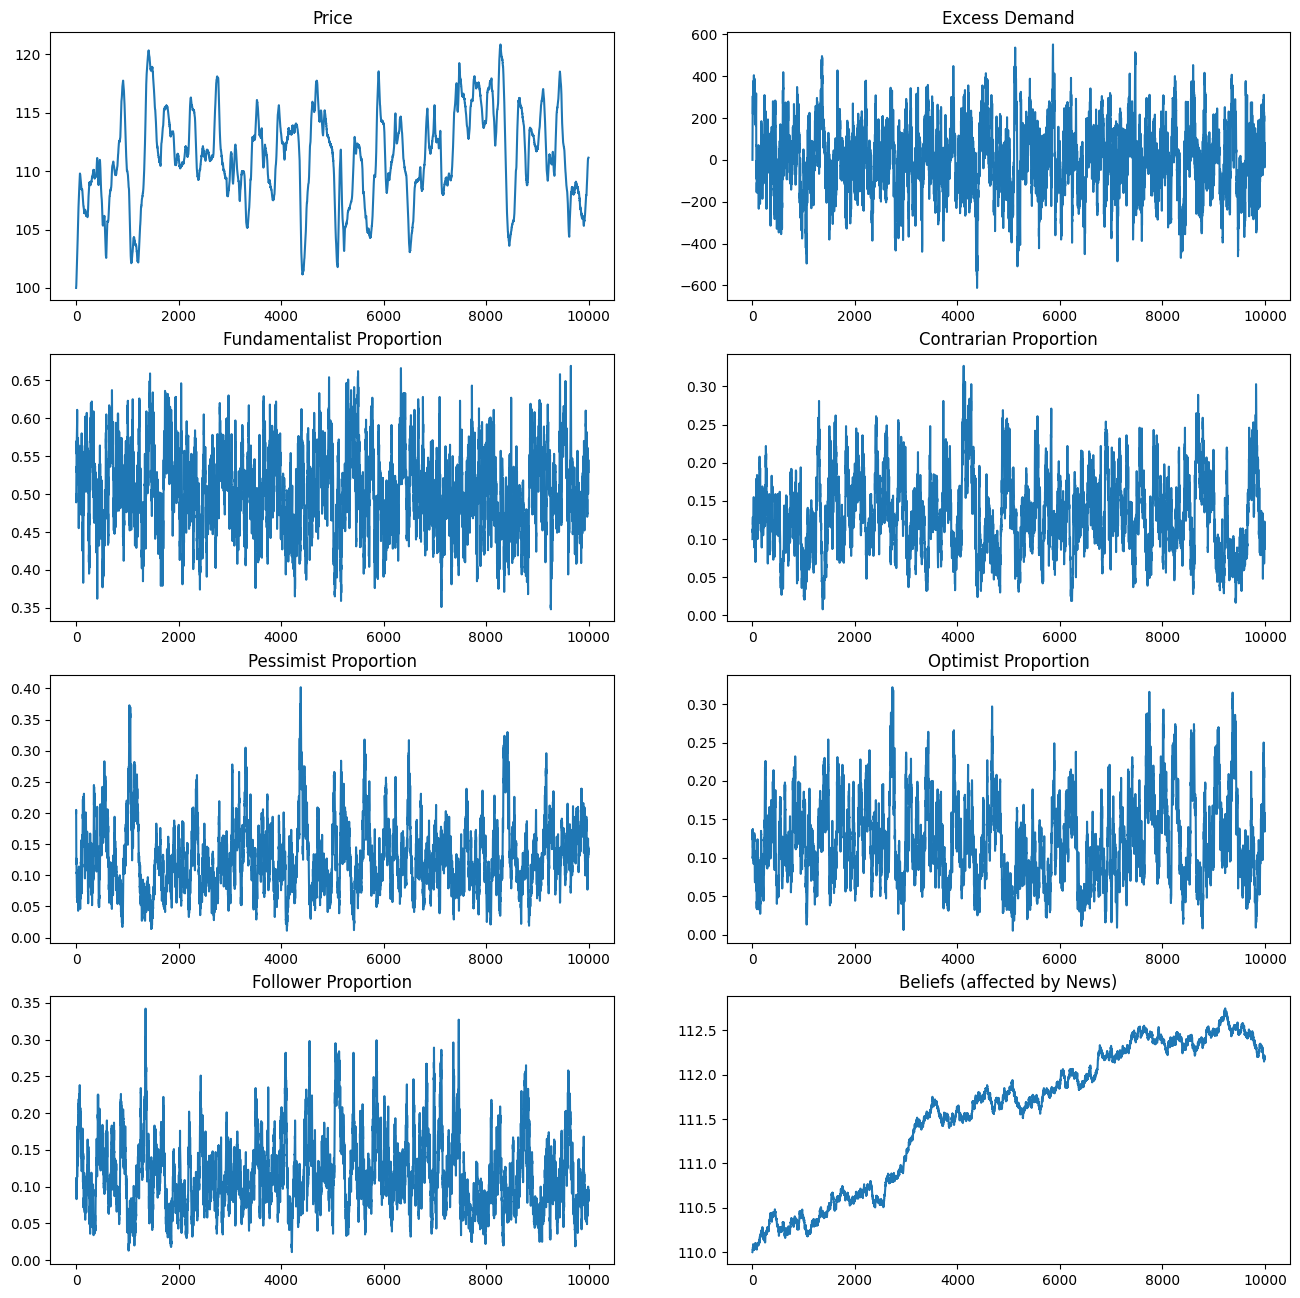

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(16, 16))
axs[0][0].plot(price)
axs[0][1].plot(excessDemand)
axs[1][0].plot(fun)
axs[1][1].plot(co)
axs[2][0].plot(pe)
axs[2][1].plot(op)
axs[3][0].plot(fo)
axs[3][1].plot(beliefs)
axs[0][0].set_title('Price')
axs[0][1].set_title('Excess Demand')
axs[1][0].set_title('Fundamentalist Proportion')
axs[1][1].set_title('Contrarian Proportion')
axs[2][0].set_title('Pessimist Proportion')
axs[2][1].set_title('Optimist Proportion')
axs[3][0].set_title('Follower Proportion')
axs[3][1].set_title('Beliefs (affected by News)')
plt.show()

<ipython-input-9-efbee1e10406>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(returns,fit=scipy.stats.norm, kde=False, hist=True, color='r');


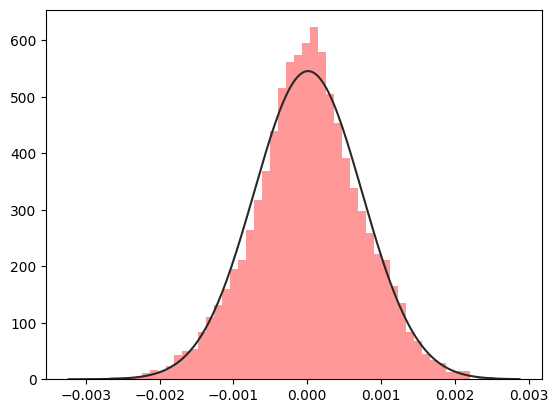

In [ ]:
# Plotting the returns distribution
returns = []
logReturns = []
for i in range(1,len(m.history)):
    r = (m.history[i] - m.history[i-1]) / m.history[i-1]
    returns.append(r)
    r = math.log(m.history[i]/m.history[i-1])
    logReturns.append(r)
import seaborn as sns
import scipy
ax = sns.distplot(returns,fit=scipy.stats.norm, kde=False, hist=True, color='r');
ax.plot()

In [ ]:
from scipy.stats import kurtosis
print("The excess kurtosis in the distribution is", kurtosis(returns, fisher=False)-3)

The excess kurtosis in the distribution is 0.2377944803009293


In [ ]:
# Big experiment
import json
big = []
for i in range(0,500,10):
    random.seed(4)
    m = Market()
    m.count = {
            "Agents" : 500,
            "Fundamentalist" : i,
            "Contrarian" : 0,
            "Follower" : 0,
            "Chartist-Optimist" : math.ceil((500-i)/2),
            "Chartist-Pessimist" : math.floor((500-i)/2)
        }
    m.initializeAgents()
    excessDemand = []
    price = []
    balance = []
    fun = []
    op = []
    pe = []
    co = []
    fo = []
    news = []
    bankruptcy = []
    beliefs = []
    for i in range(500):
        price.append(m.price)
        news.append(m.news)
        balance.append(m.balance)
        fun.append(m.count["Fundamentalist"])
        co.append(m.count["Contrarian"])
        pe.append(m.count["Chartist-Pessimist"])
        op.append(m.count["Chartist-Optimist"])
        fo.append(m.count["Follower"])
        excessDemand.append(m.excessDemand)
        bankruptcy.append(m.bankruptcyCount)
        beliefs.append(m.belief)
        m.timeStep()
    big.append((price,news,balance,fun,co,pe,op,fo,excessDemand,bankruptcy,beliefs))
# with open("dump1.txt","w") as f:
#     json.dump(big,f)

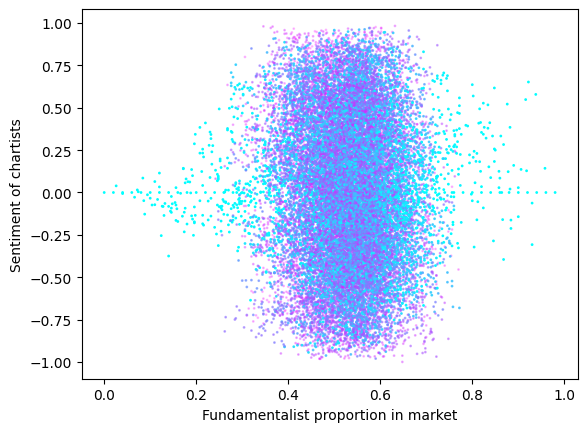

In [ ]:
import matplotlib.pylab as pl
colors = pl.cm.jet(np.linspace(0,1,len(big)))
for i in range(len(big)):
    x = [j/500 for j in big[i][3]]
    y = [(big[i][6][j] - big[i][5][j])/(big[i][6][j] + big[i][5][j]) for j in range(len(big[i][5]))]
    plt.scatter(x,y,alpha=np.linspace(1,0.2,len(x)),c = np.linspace(0,1,len(x)),cmap = "cool",s = 1)
plt.xlabel("Fundamentalist proportion in market")
plt.ylabel("Sentiment of chartists")
plt.savefig("attractor.png")